In [1]:
import transformers

In [2]:
print(transformers.__version__)

4.34.1


In [3]:
import torch
print(torch.__version__)

2.1.1


In [4]:
from transformers import DistilBertTokenizer
from transformers import DistilBertForSequenceClassification
from transformers import TextClassificationPipeline

import tensorflow as tf
import pandas as pd
import json
import gc
import numpy as np

from sklearn.model_selection import train_test_split

import re
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# from nltk.corpus import stopwords
# stopw = stopwords.words('english')

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

from tqdm import tqdm

In [5]:
root_path = './datasets/post_sub_new.csv'

In [6]:
df = pd.read_csv(root_path)
# only keep 100 rows in df
print(df.head())

                                                post subreddit
0  med First I give background medical history I ...      adhd
1  Concerta working first day Update Thank insigh...      adhd
2  Comorbid anxiety Medication Question Hi I rece...      adhd
3  Fist Day Concerta 18mg UPDATE Update Thank ins...      adhd
4  I absolutely hate motivated equally incompeten...      adhd


In [7]:
# Get indexes of rows where subreddit is 'depression'
depression_rows = df[df['subreddit'] == 'depression'].index

# Calculate the number of rows to keep and remove for 'depression' subreddit
total_depression_rows = len(depression_rows)
rows_to_keep = int(total_depression_rows * 0.50)  # 59% of the rows to keep

# Randomly select 50% of the rows to keep
rows_to_keep_indexes = np.random.choice(depression_rows, size=rows_to_keep, replace=False)

# Get the indexes of rows to remove
rows_to_remove_indexes = depression_rows.difference(rows_to_keep_indexes)

# Remove 50% of rows with subreddit 'depression'
df.drop(rows_to_remove_indexes, inplace=True)

In [8]:
# Get indexes of rows where subreddit is 'suicidewatch'
s_rows = df[df['subreddit'] == 'suicidewatch'].index

# Calculate the number of rows to keep and remove for 'suicidewatch' subreddit
total_s_rows = len(s_rows)
rows_to_keep = int(total_s_rows * 0.75)  # 75% of the rows to keep

# Randomly select 75% of the rows to keep
rows_to_keep_indexes = np.random.choice(s_rows, size=rows_to_keep, replace=False)

# Get the indexes of rows to remove
rows_to_remove_indexes = s_rows.difference(rows_to_keep_indexes)

# Remove 25% of rows with subreddit 'suicidewatch'
df.drop(rows_to_remove_indexes, inplace=True)

In [9]:
df_oversampled = df

In [10]:
# print unique values in subreddit column
print(df_oversampled['subreddit'].value_counts())

subreddit
depression       58665
anxiety          57671
suicidewatch     49620
adhd             45631
bpd              24294
lonely           23635
autism            8869
schizophrenia     8712
ptsd              8643
addiction         7641
alcoholism        5911
Name: count, dtype: int64


In [11]:
df_oversampled.shape

(299292, 2)

# Histogram of the count of text

In [12]:
df_oversampled = df_oversampled.dropna()

In [13]:
df_oversampled['count'] = df_oversampled['post'].apply(lambda x: len(x.split()))

/var/folders/yq/4r6p5rr91jl0sq8dt61vf_f00000gn/T/ipykernel_2758/1106335281.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
df_oversampled.head()

,post,subreddit,count
0,med First I give background medical history I ...,adhd,80
1,Concerta working first day Update Thank insigh...,adhd,86
2,Comorbid anxiety Medication Question Hi I rece...,adhd,64
3,Fist Day Concerta 18mg UPDATE Update Thank ins...,adhd,81
4,I absolutely hate motivated equally incompeten...,adhd,45


<Figure size 800x800 with 0 Axes>

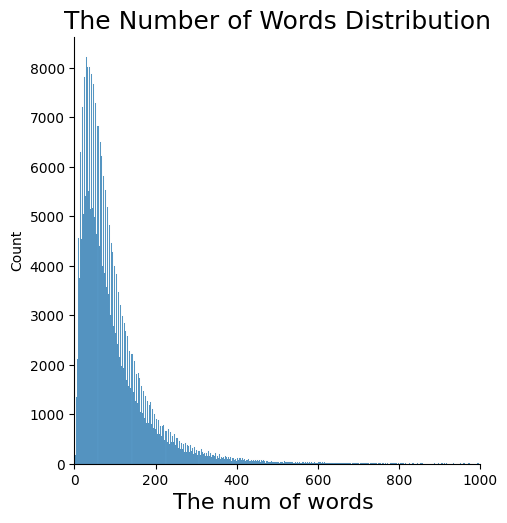

In [15]:
plt.figure(figsize= (8, 8))

sns.displot(df_oversampled['count'])

plt.xlim(0, 1000)

plt.xlabel('The num of words ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()

# Bar plot for each of the new category

In [16]:
category_count = df_oversampled['subreddit'].value_counts()

categories = category_count.index

print(categories)

Index(['depression', 'anxiety', 'suicidewatch', 'adhd', 'bpd', 'lonely',
       'autism', 'schizophrenia', 'ptsd', 'addiction', 'alcoholism'],
      dtype='object', name='subreddit')


In [17]:
category_count

subreddit
depression       58664
anxiety          57671
suicidewatch     49620
adhd             45631
bpd              24293
lonely           23635
autism            8869
schizophrenia     8712
ptsd              8643
addiction         7641
alcoholism        5911
Name: count, dtype: int64

In [18]:
category_count.index

Index(['depression', 'anxiety', 'suicidewatch', 'adhd', 'bpd', 'lonely',
       'autism', 'schizophrenia', 'ptsd', 'addiction', 'alcoholism'],
      dtype='object', name='subreddit')

Text(0.5, 1.0, 'The posts by Subreddit')

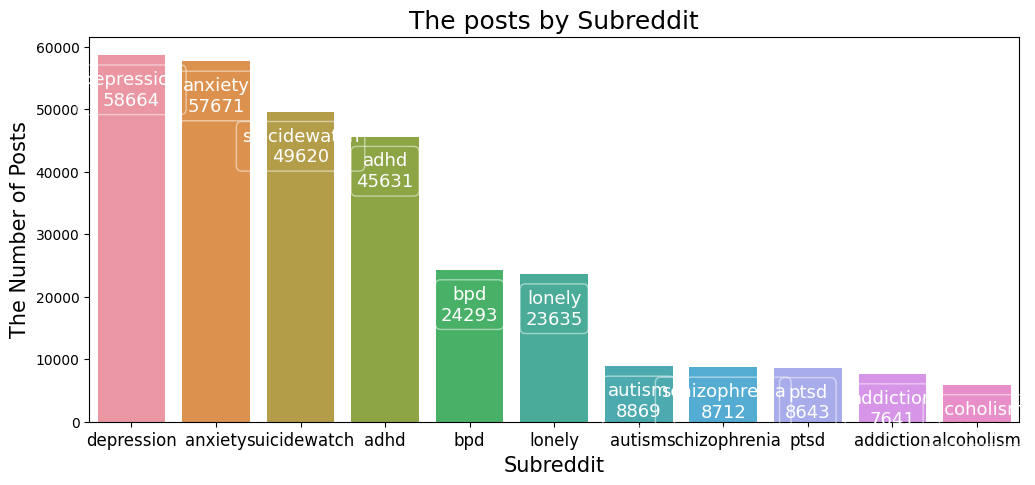

In [19]:
fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = category_count.index, y = category_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )
    
plt.xlabel('Subreddit', size = 15)

plt.ylabel('The Number of Posts', size= 15)

plt.xticks(size = 12)

plt.title("The posts by Subreddit" , size = 18)

# plt.show()

In [20]:
df_oversampled['subreddit'].unique()

array(['adhd', 'autism', 'ptsd', 'suicidewatch', 'lonely', 'alcoholism',
       'schizophrenia', 'depression', 'addiction', 'anxiety', 'bpd'],
      dtype=object)

In [21]:
df_oversampled['encoded_text'] = df_oversampled['subreddit'].astype('category').cat.codes

/var/folders/yq/4r6p5rr91jl0sq8dt61vf_f00000gn/T/ipykernel_2758/1924527632.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:

# Find all posts that start with "I need help"
# df_oversampled[df_oversampled['post'].str.startswith('I need help')]

In [23]:
data_texts = df_oversampled['post'].to_list()

data_labels = df_oversampled['encoded_text'].to_list()

# Train Test SPlit

In [28]:
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size = 0.2, random_state = 42 )


train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size = 0.25, random_state = 42 )


# Model Definition

In [27]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
print("Started Tokenizer")

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=300, return_tensors='pt')
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=300, return_tensors='pt')

Started Tokenizer


In [28]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [29]:
train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)

In [32]:
def compute_accuracy(preds, labels):
    """
    Computes the accuracy given the predictions and actual labels.
    """
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(preds_flat == labels_flat) / len(labels_flat)

In [33]:
import torch
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

# Assuming you have your train_dataset and val_dataset defined as Dataset objects

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=11)

train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)


# Define accuracy calculation function



# Initialize Trainer
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=1e-4,
    logging_dir='./logs',
    evaluation_strategy="steps",
    eval_steps=2000,
    save_strategy="steps",
    save_steps=22000
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda pred: {'accuracy': compute_accuracy(pred.predictions, pred.label_ids)}
)

# Train the model
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy
2000,0.862000,0.822339,0.726407
4000,0.766100,0.782312,0.740657
6000,0.735900,0.740157,0.749962
8000,0.733800,0.720885,0.755910
10000,0.722200,0.730010,0.752619
12000,0.721500,0.693262,0.761974
14000,0.697600,0.687798,0.765131
16000,0.598800,0.723240,0.764981
18000,0.603000,0.696795,0.767604
20000,0.599100,0.678858,0.770394


TrainOutput(global_step=74075, training_loss=0.48046890384958596, metrics={'train_runtime': 29536.3098, 'train_samples_per_second': 40.126, 'train_steps_per_second': 2.508, 'total_flos': 9.2005999490727e+16, 'train_loss': 0.48046890384958596, 'epoch': 5.0})

In [34]:
# Evaluate the model
evaluation_metrics = trainer.evaluate()
print(f"Accuracy: {evaluation_metrics['eval_accuracy']}")

Accuracy: 0.7724819993651748


In [35]:
# Save the model and tokenizer
save_directory = "./savedmodels_new"
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('./savedmodels_new/tokenizer_config.json',
 './savedmodels_new/special_tokens_map.json',
 './savedmodels_new/vocab.txt',
 './savedmodels_new/added_tokens.json')

In [36]:
print(evaluation_metrics)

{'eval_loss': 1.0022987127304077, 'eval_accuracy': 0.7724819993651748, 'eval_runtime': 290.9231, 'eval_samples_per_second': 205.755, 'eval_steps_per_second': 6.431, 'epoch': 5.0}


# Saving & Loading the model

# Loading Pre-Trained Model

In [ ]:
tokenizer_fine_tuned = DistilBertTokenizer.from_pretrained(save_directory)

model_fine_tuned = DistilBertForSequenceClassification.from_pretrained(save_directory)

pred = []

for test_text in test_texts:
    predict_input = tokenizer_fine_tuned.encode_plus(
        test_text,
        truncation=True,
        padding='max_length',
        max_length=300,
        return_tensors='pt'
    )

    output = model_fine_tuned(**predict_input)[0]

    prediction_value = torch.argmax(output, axis=1).item()
    pred.append(prediction_value)

In [53]:
total = len(pred)
correct = 0
for i in range(len(pred)):
    if pred[i] == test_labels[i]:
        correct += 1

print((float(correct)/float(total)))

0.7741127348643007


In [55]:
import wandb
wandb.log({'test_acc': (float(correct)/float(total))})